# Сервис на трансформерах

### **Задача:** Построить ML-сервис с использованием трансформеров с графическим интерфейсом и доступный в интернете

На текущий момент демо-сервис классификации научных статей по темам доступен по следующим ссылкам:

1. **Телеграм-бот**: [https://t.me/arxiv_topic_classifier_bot](https://t.me/arxiv_topic_classifier_bot)
2. **Веб-сервер**: [http://77.73.71.233:7860](http://77.73.71.233:7860)

## Этапы решения задачи:

1. Выбор задачи
2. Планирование решения
3. Сбор данных
4. Изучение данных
5. Подготовка датасета
6. Выбор базовой классической модели
7. Обучение классической модели
8. Оценка классической модели
9. Обучение трансформера
10. Оценка модели на базе трансформеров
11. Сбор дополнительных данных
12. Подготовка нового датасета
13. Обучение модели
14. Оценка модели
15. Попытка обучить ещё бóльшую модель
16. Выбор модели для прода
17. Создание сервисов вокруг обученной модели
18. Подготовка сервера для размещения проекта
19. Настройка всех компонентов проекта на сервере
20. Запуск и тестирование развёрнутого сервиса

## 1. Выбор задачи

В качестве типовой задачи, которую имеет смысл решать с помощью трансформеров, предлагается задача классификации научных статей по темам. Так как задание направлено на отработку управления полным циклом разработки сервиса (начиная сбором данных и заканчивая развёрнутым сервисом с графическим интерфейсом), то искать какую-то специальную задачу машинного обучения не представляется целесообразным и можно взять предложенную, то есть:

> Нужно построить сервис который принимает название статьи и её abstract, и выдаёт наиболее вероятную тематику статьи: скажем, физика, биология или computer science. В интерфейсе должно быть можно ввести отдельно abstract, отдельно название - и увидеть топ-95% тематик, отсортированных по убыванию вероятности. Если abstract не ввели, нужно классифицировать статью только по названию.

## 2. Планирование решения

**Глобально задача состоит из 4-х этапов:**

1. Сбор данных
2. Эксперименты с моделями и выбор лучшей
3. Оборачивание модели в сервис
4. Развёртывание сервиса на сервере с доступом из интернета

### Сбор данных

Для первого этапа предлагается взять готовый датасет с метаинформацией о научных статьях, выкладываемых на [arxiv](https://www.kaggle.com/neelshah18/arxivdataset/). Сам датасет есть на kaggle, но данные там представлены не за все годы, а только до 2018-го, поэтому, возможно, потребуется либо найти другой датасет с более полными данными, либо самостоятельно спарсить недостающие данные по API.

Сначала попробуем поработать с датасетом с kaggle, а затем, в случае необходимости, увеличим его.

### Эксперименты с моделями и выбор лучшей

Не смотря на то, что в задании предлагается начать сразу с модели distilbert-base-cased, построенной на трансформерах, начал с самого простого классического классификатора на базе логистической регрессии по следующим причинам:

- Трансформеры банально дольше учатся и у них более дорогой инференс. Можно потратить время на исследования и получить модель, которая по качеству будет хуже или сопоставима с простейшей логистической регрессией, и тогда не будет никакого смысла использовать навороченную модель в проде, - вполне можно взять классическую.
- Классические модели обучаются быстрее, а значит, скорость итеративного улучшения выше. В том смысле, что если есть какие-то проблемы с данными, самой задачей, подходами, это выяснится быстрее, чем когда брать сразу тяжёлые модели.
- Когда сервис уже работает в продакшн потенциально возможны систуации резкого возрастания нагрузки и тяжёлая модель может оказаться перегруженной. Если мы ограничены в ресурсах для горизонтального масштабирования, то поднять несколько инстансов тяжёлой модели может быть не только экономически нецелесообразно, но и невозможно. И чтобы радикально не ухудшать пользовательский опыт - лучше часть запросов перенаправить на менее точную, но маленькую и быструю модель.

После того как будет обучена какая-нибудь классическая ML-модель для классификации и зафиксированы её результаты на тестовой выборке - можно обучить простой трансформер. Если после этого останется серьёзное пространство для улучшения (в том числе время) - можно будет попробовать собрать дополнительные данные, попробовать обучить другие модели.

По итогу нужно будет выбрать модель, которая пойдёт в прод.

### Оборачивание модели в сервис

Для того, чтобы обученная модель приносила пользу - необходимо создать вокруг неё полноценный сервис, доступный 24/7 и с удобным интерфейсом. Архитектурно это может выглядеть так:

1. Веб-сервер на gradio, через который происходит взаимодействие пользователя с моделью
2. Чтобы модель не загружалась в память заново на каждый запрос каждого пользователя её можно вынести в отдельный микросервис.
3. Микросервисы связать брокером сообщений

Также в качестве интерфейся для взаимодействия с пользователем можно использовать телеграм-бота на поллинге. Плюс такого интерфейса в том, что не требуется иметь белый IP-адрес, по которому должен быть доступен веб-сервер.

### Развёртывание сервиса на сервере с доступом из интернета

Развернуть весь проект на сервере можно несколькими способами:

1. Каждый компонент установить в систему и настроить его. Для веб-сервера, воркера и бота создать systemd-юниты для автоматизации запуска.
2. Каждый компонент развернуть в докер-контейнере. Веб-сервер, воркер и бота сбилдить из докер-файла.
3. Инфраструктурные компоненты (СУБД, очередь) развернуть в докере, а для веб-сервера, воркера и бота создать systemd-юниты.
4. Инфраструктурные компоненты установить в систему, а веб-сервер, воркера и бота поднять в докере.

 Оптимальным выглядит второй вариант. Он может быть осложнён необходимостью разбираться с NVIDIA Docker, поэтому ML-модель оставил отдельным сервисом в systemd, а всё остальное в докере.

## 3. Сбор данных

Первоначальный датасет для задачи лежит на kaggle. Скачать его легко вручную, чтобы не вспоминать где креды для API и не заниматься получением новых. Сохраним скачанный архив в директории **./raw_data**, затем распакуем в эту же директорию.

In [ ]:
# Импортируем необходимые библиотеки и объекты
import json
import os
import time
from ast import literal_eval
from datetime import datetime, timedelta

import arxiv
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
from bs4 import BeautifulSoup
from datasets import Dataset, DatasetDict
from dateutil import parser
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    Trainer,
    TrainingArguments,
)

In [ ]:
# Распаковываем архив в директорию /raw_data
!unzip raw_data/archive.zip -d raw_data

Archive:  raw_data/archive.zip
  inflating: raw_data/arxivData.json  


In [ ]:
# Загрузим файл
with open("raw_data/arxivData.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

## 4. Изучение данных

Посмотрим на структуру данных и решим в каком виде будем их использовать для подготовки датасета.

In [ ]:
# Посмотрим на первую строчку файла, чтобы понять его структуру
print(raw_data[0])

{'author': "[{'name': 'Ahmed Osman'}, {'name': 'Wojciech Samek'}]", 'day': 1, 'id': '1802.00209v1', 'link': "[{'rel': 'alternate', 'href': 'http://arxiv.org/abs/1802.00209v1', 'type': 'text/html'}, {'rel': 'related', 'href': 'http://arxiv.org/pdf/1802.00209v1', 'type': 'application/pdf', 'title': 'pdf'}]", 'month': 2, 'summary': 'We propose an architecture for VQA which utilizes recurrent layers to\ngenerate visual and textual attention. The memory characteristic of the\nproposed recurrent attention units offers a rich joint embedding of visual and\ntextual features and enables the model to reason relations between several\nparts of the image and question. Our single model outperforms the first place\nwinner on the VQA 1.0 dataset, performs within margin to the current\nstate-of-the-art ensemble model. We also experiment with replacing attention\nmechanisms in other state-of-the-art models with our implementation and show\nincreased accuracy. In both cases, our recurrent attention mech

То есть каждая строка такого файла - это данные одной статьи. Из этого нам понадобятся название статьи (**title**), описание статьи (**summary**) и ключ темы, к которым относится статья (лежат в списке по ключу **tag** по ключам **term**). Каждая статья может относиться к нескольким темам. Причём списки в JSON выглядят как строки, поэтому их нужно десериализовать.

Также добавим в датасет год статьи, чтобы понять какие годы присутствуют в наборе.

In [ ]:
# Функция, которая из каждой записи о статье сформирует словарь с ключами `year`, `title`, `summary`, `tags`
def parse_article_data_json(entry):
    try:
        tags_raw = literal_eval(entry["tag"])
        tags = [tag_dict["term"] for tag_dict in tags_raw]
    except (ValueError, SyntaxError, KeyError):
        tags = []

    return {
        "year": entry.get("year", None),
        "title": entry.get("title", "").strip(),
        "summary": entry.get("summary", "").replace("\n", " ").strip(),
        "tags": tags
    }

In [ ]:
# Создадим датафрейм из всех записей файла
df = pd.DataFrame([parse_article_data_json(article) for article in raw_data])

In [ ]:
df.head(10)

,year,title,summary,tags
0,2018,Dual Recurrent Attention Units for Visual Ques...,We propose an architecture for VQA which utili...,"[cs.AI, cs.CL, cs.CV, cs.NE, stat.ML]"
1,2016,Sequential Short-Text Classification with Recu...,Recent approaches based on artificial neural n...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]"
2,2016,Multiresolution Recurrent Neural Networks: An ...,We introduce the multiresolution recurrent neu...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML, I.5.1; I..."
3,2017,Learning what to share between loosely related...,Multi-task learning is motivated by the observ...,"[stat.ML, cs.AI, cs.CL, cs.LG, cs.NE]"
4,2017,A Deep Reinforcement Learning Chatbot,We present MILABOT: a deep reinforcement learn...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML, I.5.1; I..."
5,2017,Generating Sentences by Editing Prototypes,We propose a new generative model of sentences...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]"
6,2018,A Deep Reinforcement Learning Chatbot (Short V...,We present MILABOT: a deep reinforcement learn...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML, I.5.1; I..."
7,2016,Document Image Coding and Clustering for Scrip...,The paper introduces a new method for discrimi...,"[cs.CV, cs.AI, cs.CL, cs.LG, cs.NE, 97R40, 62H..."
8,2016,Tutorial on Answering Questions about Images w...,Together with the development of more accurate...,"[cs.CV, cs.AI, cs.CL, cs.LG, cs.NE]"
9,2017,pix2code: Generating Code from a Graphical Use...,Transforming a graphical user interface screen...,"[cs.LG, cs.AI, cs.CL, cs.CV, cs.NE, 68T45, I.2..."


In [ ]:
# Максимальный год статей в датасете
df.year.max()

2018

In [ ]:
# Минимальный год статей в датасете
df.year.min()

1993

In [ ]:
# Количество строк
df.shape[0]

41000

In [ ]:
# Проверим дубликаты
df.duplicated(subset=['title', 'summary']).sum()

14

In [ ]:
# Удалим дубликаты
df.drop_duplicates(subset=['title', 'summary'])

,year,title,summary,tags
0,2018,Dual Recurrent Attention Units for Visual Ques...,We propose an architecture for VQA which utili...,"[cs.AI, cs.CL, cs.CV, cs.NE, stat.ML]"
1,2016,Sequential Short-Text Classification with Recu...,Recent approaches based on artificial neural n...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]"
2,2016,Multiresolution Recurrent Neural Networks: An ...,We introduce the multiresolution recurrent neu...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML, I.5.1; I..."
3,2017,Learning what to share between loosely related...,Multi-task learning is motivated by the observ...,"[stat.ML, cs.AI, cs.CL, cs.LG, cs.NE]"
4,2017,A Deep Reinforcement Learning Chatbot,We present MILABOT: a deep reinforcement learn...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML, I.5.1; I..."
...,...,...,...,...
40995,2014,Nearly Tight Bounds on $\ell_1$ Approximation ...,We study the complexity of learning and approx...,"[cs.LG, cs.DS]"
40996,2014,Concurrent bandits and cognitive radio networks,We consider the problem of multiple users targ...,"[cs.LG, cs.MA]"
40997,2014,A Comparison of Clustering and Missing Data Me...,"In this paper, we compare and analyze clusteri...","[math.NA, cs.LG, 62H30, 91C20, 94A08]"
40998,2014,Applying machine learning to the problem of ch...,Cylindrical algebraic decomposition(CAD) is a ...,"[cs.SC, cs.LG, 68W30, 68T05, O3C10, I.2.6]"


## 5. Подготовка датасета

Для того, чтобы перевести коды тем в сами темы, необходимо спарсить классификатор с arxiv.org, который находится здесь: [https://arxiv.org/category_taxonomy](https://arxiv.org/category_taxonomy).

In [ ]:
# Получим всю страницу с классификатором кодов по темам
response = requests.get("https://arxiv.org/category_taxonomy")
response.raise_for_status()

In [ ]:
# Распарсим HTML в объект BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

In [ ]:
# Найдём элемент div, который отвечает за список кодов
main_div = soup.find("div", id="category_taxonomy_list")

In [ ]:
# Создадим словарь, в который сохраним списки кодов по ключам тем
taxonomy = {}

In [ ]:
# Получим список кодов для каждой темы и сохраним в словарь
for h2 in main_div.find_all("h2", class_="accordion-head"):
    category_name = h2.get_text(strip=True)
    category_div = h2.find_next_sibling("div")

    subcategories = []
    for h4 in category_div.find_all("h4"):
        if h4.contents:
            code = h4.contents[0].strip()  # только первый текстовый узел — код
            subcategories.append(code)

    taxonomy[category_name] = subcategories

In [ ]:
# Проверим, что получилось то, что ожидается
for category, codes in taxonomy.items():
    print(f"{category}: {codes[:5]}...")

Computer Science: ['cs.AI', 'cs.AR', 'cs.CC', 'cs.CE', 'cs.CG']...
Economics: ['econ.EM', 'econ.GN', 'econ.TH']...
Electrical Engineering and Systems Science: ['eess.AS', 'eess.IV', 'eess.SP', 'eess.SY']...
Mathematics: ['math.AC', 'math.AG', 'math.AP', 'math.AT', 'math.CA']...
Physics: ['astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE', 'astro-ph.IM']...
Quantitative Biology: ['q-bio.BM', 'q-bio.CB', 'q-bio.GN', 'q-bio.MN', 'q-bio.NC']...
Quantitative Finance: ['q-fin.CP', 'q-fin.EC', 'q-fin.GN', 'q-fin.MF', 'q-fin.PM']...
Statistics: ['stat.AP', 'stat.CO', 'stat.ME', 'stat.ML', 'stat.OT']...


In [ ]:
# Для того, чтобы было проще преобразовать коды в темы в датафрейме "развернём" словарь так, чтобы кодами были ключи, а значениями - темы
tag_to_topic = {}
for topic, tag_list in taxonomy.items():
    for tag in tag_list:
        tag_to_topic[tag] = topic

In [ ]:
# Добавим в датафрейм колонку topics со списками тем статьи
df['topics'] = df['tags'].apply(lambda x: list({tag_to_topic.get(tag) for tag in x if tag in tag_to_topic}))

In [ ]:
df.head(10)

,year,title,summary,tags,topics
0,2018,Dual Recurrent Attention Units for Visual Ques...,We propose an architecture for VQA which utili...,"[cs.AI, cs.CL, cs.CV, cs.NE, stat.ML]","[Statistics, Computer Science]"
1,2016,Sequential Short-Text Classification with Recu...,Recent approaches based on artificial neural n...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]","[Statistics, Computer Science]"
2,2016,Multiresolution Recurrent Neural Networks: An ...,We introduce the multiresolution recurrent neu...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML, I.5.1; I...","[Statistics, Computer Science]"
3,2017,Learning what to share between loosely related...,Multi-task learning is motivated by the observ...,"[stat.ML, cs.AI, cs.CL, cs.LG, cs.NE]","[Computer Science, Statistics]"
4,2017,A Deep Reinforcement Learning Chatbot,We present MILABOT: a deep reinforcement learn...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML, I.5.1; I...","[Statistics, Computer Science]"
5,2017,Generating Sentences by Editing Prototypes,We propose a new generative model of sentences...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]","[Statistics, Computer Science]"
6,2018,A Deep Reinforcement Learning Chatbot (Short V...,We present MILABOT: a deep reinforcement learn...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML, I.5.1; I...","[Statistics, Computer Science]"
7,2016,Document Image Coding and Clustering for Scrip...,The paper introduces a new method for discrimi...,"[cs.CV, cs.AI, cs.CL, cs.LG, cs.NE, 97R40, 62H...",[Computer Science]
8,2016,Tutorial on Answering Questions about Images w...,Together with the development of more accurate...,"[cs.CV, cs.AI, cs.CL, cs.LG, cs.NE]",[Computer Science]
9,2017,pix2code: Generating Code from a Graphical Use...,Transforming a graphical user interface screen...,"[cs.LG, cs.AI, cs.CL, cs.CV, cs.NE, 68T45, I.2...",[Computer Science]


In [ ]:
# Добавим в датафрейм колонку `text`, объединяющую `title` и `summary`
df['text'] = df['title'] + ' ' + df['summary']

In [ ]:
# Целевая переменная находится в колонке topics
y = df['topics']

## 6. Выбор базовой классической модели

In [ ]:
# Так как каждую статью потенциально можно отнести к нескольким классам, то это задача классификации с множественными метками
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(y)

In [ ]:
# Для классических моделей машинного обучения подойдёт TF-IDF-векторизация
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['text'])

In [ ]:
# Разбиваем датасет на тренировочную и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Так как у нас задача мультилейбловой классификации, а логистическая регрессия решает по умолчанию мультиклассовую задачу, то нужно, чтобы каждый класс решался независимо, как отдельная бинарная классификация:
```
document → Physics?   → 0.95
document → Math?      → 0.88
document → Econ?      → 0.03
```

Для этого нужно взять `OneVsRestClassifier(LogisticRegression)`, который обучит `n` независимых моделей логистической регрессии.

In [ ]:
# Модель для мультилейбловой классификации
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))

## 7. Обучение классической модели

In [ ]:
# Обучим модель
clf.fit(X_train, Y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

## 8. Оценка классической модели

In [ ]:
# Получим предсказания модели на тесте
Y_pred = clf.predict(X_test)

In [ ]:
# Выведем отчёт
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_, zero_division=0))

                                            precision    recall  f1-score   support

                          Computer Science       0.96      1.00      0.98      7843
                                 Economics       0.00      0.00      0.00         4
Electrical Engineering and Systems Science       0.00      0.00      0.00        50
                               Mathematics       0.66      0.12      0.21       430
                                   Physics       0.82      0.06      0.11       242
                      Quantitative Biology       0.77      0.09      0.17       182
                      Quantitative Finance       0.00      0.00      0.00        13
                                Statistics       0.75      0.61      0.67      2134

                                 micro avg       0.92      0.84      0.88     10898
                                 macro avg       0.50      0.24      0.27     10898
                              weighted avg       0.89      0.84      0.85 

Разберём показатели по каждому классу.

##### Computer Science

- Precision: **0.96**
- Recall: **1.00**
- F1: **0.98**

Самый большой класс. Модель почти не ошибается и находит всё.

##### Economics, Electrical Engineering and Systems Science, Quantitative Finance

- Precision: **0**
- Recall: **0**
- F1: **0**

Это значит, что модель вообще ни одного раза не предсказала эти метки из-за очень низкой представленности образцов данных классов. Логистическая регрессия не научилась для них.

##### Physics, Mathematics, Quantitative Biology

- Recall очень низкий (6–12%), значит модель почти не находит их.
- Хотя Precision неплохой — модель редко, но точно угадывает.

##### Statistics

- Precision: **0.75**
- Recall: **0.61**
- F1: **0.67**

Единственный малый класс, где всё ещё приемлемый recall и F1.

Очевидно, что датасет сильно несбалансированный, а потому модель показывает плохие результаты. Для наглядности можно построить график представленности тем в датасете.

In [ ]:
# Подготовим данные для графика
topic_counts = df["topics"].explode().value_counts().sort_values(ascending=False).reset_index()
topic_counts.columns = ["topic", "count"]

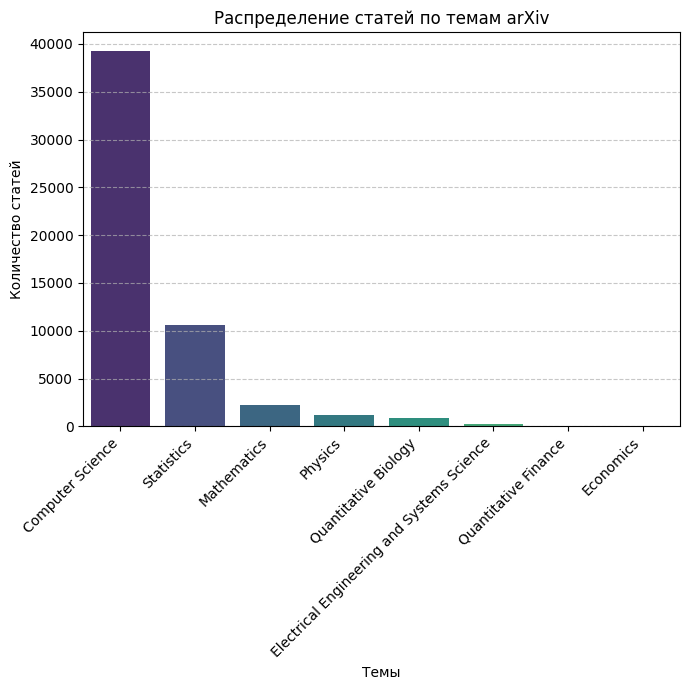

In [ ]:
# Построим график распределения статей по темам
plt.figure(figsize=(7, 7))
sns.barplot(
    data=topic_counts,
    x="topic",
    y="count",
    hue="topic",
    dodge=False,
    palette="viridis",
    legend=False
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Темы")
plt.ylabel("Количество статей")
plt.title("Распределение статей по темам arXiv")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Ну, или в цифрах
topic_counts

,topic,count
0,Computer Science,39251
1,Statistics,10618
2,Mathematics,2263
3,Physics,1208
4,Quantitative Biology,896
5,Electrical Engineering and Systems Science,220
6,Quantitative Finance,66
7,Economics,13


Даже для классических моделей машинного обучения, из-за такой маленькой представленности некоторых классов, данных просто мало. Уже понятно, что нужно искать данные дополнительно. Но для начала всё же попробуем обучить `distilbert` на имеющихся, чтобы увидеть разницу, по сравнению с логистической регрессией.

## 9. Обучение трансформера

In [ ]:
mlb.classes_

array(['Computer Science', 'Economics',
       'Electrical Engineering and Systems Science', 'Mathematics',
       'Physics', 'Quantitative Biology', 'Quantitative Finance',
       'Statistics'], dtype=object)

In [ ]:
# Подготовим общий датасет с темами
labels_df = pd.DataFrame(Y, columns=mlb.classes_)
df_encoded = pd.concat([df[["text"]], labels_df], axis=1)

In [ ]:
df_encoded.head()

,text,Computer Science,Economics,Electrical Engineering and Systems Science,Mathematics,Physics,Quantitative Biology,Quantitative Finance,Statistics
0,Dual Recurrent Attention Units for Visual Ques...,1,0,0,0,0,0,0,1
1,Sequential Short-Text Classification with Recu...,1,0,0,0,0,0,0,1
2,Multiresolution Recurrent Neural Networks: An ...,1,0,0,0,0,0,0,1
3,Learning what to share between loosely related...,1,0,0,0,0,0,0,1
4,A Deep Reinforcement Learning Chatbot We prese...,1,0,0,0,0,0,0,1


In [ ]:
# Разделим датасет на трейн и тест
train_df, val_df = train_test_split(df_encoded, test_size=0.1, random_state=42)

In [ ]:
# Инициализируем токенайзер
model_name = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Преобразуем трейн и тест в экземпляры `Dataset`
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
# Подготовим функцию для токенизации датасета
def tokenize_and_format(example):
    tokens = tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )
    tokens["labels"] = [float(example[topic]) for topic in mlb.classes_]
    return tokens

In [ ]:
# Токенизируем датасет
train_dataset = train_dataset.map(tokenize_and_format)
val_dataset = val_dataset.map(tokenize_and_format)

Map:   0%|          | 0/36900 [00:00<?, ? examples/s]

Map:   0%|          | 0/4100 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['text', 'Computer Science', 'Economics', 'Electrical Engineering and Systems Science', 'Mathematics', 'Physics', 'Quantitative Biology', 'Quantitative Finance', 'Statistics', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 36900
})

In [ ]:
# Удалим ненужные колонки из датасета
train_dataset = train_dataset.remove_columns(train_df.columns.difference(["text"] + mlb.classes_).tolist())
val_dataset = val_dataset.remove_columns(val_df.columns.difference(["text"] + mlb.classes_).tolist())

In [ ]:
train_dataset

Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 36900
})

In [ ]:
# Инициализируем модель
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Подготовим функцию для вычисления метрик
def compute_metrics(pred):
    logits, labels = pred
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    labels = labels.astype(int)
    return {
        "f1_micro": f1_score(labels, preds, average="micro"),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

In [ ]:
# Настроим параметры обучения модели
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
)

In [ ]:
# Инициализируем трейнер
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
# Обучим модель
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.098500,0.096623,0.885409,0.320991
2,0.090300,0.094051,0.893750,0.427343
3,0.075600,0.096763,0.889097,0.435684


TrainOutput(global_step=13839, training_loss=0.09283345882168514, metrics={'train_runtime': 1498.5863, 'train_samples_per_second': 73.87, 'train_steps_per_second': 9.235, 'total_flos': 1.46657101160448e+16, 'train_loss': 0.09283345882168514, 'epoch': 3.0})

## 10. Оценка модели на базе трансформеров

In [ ]:
# Посчитаем метрики
predictions = trainer.predict(val_dataset)
preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()
true = predictions.label_ids.astype(int)

In [ ]:
# Выведем отчёт
print(classification_report(true, preds, target_names=mlb.classes_, zero_division=0))

                                            precision    recall  f1-score   support

                          Computer Science       0.96      1.00      0.98      3930
                                 Economics       0.00      0.00      0.00         2
Electrical Engineering and Systems Science       0.00      0.00      0.00        26
                               Mathematics       0.57      0.27      0.37       208
                                   Physics       0.60      0.58      0.59       118
                      Quantitative Biology       0.69      0.45      0.54        94
                      Quantitative Finance       0.33      0.17      0.22         6
                                Statistics       0.70      0.75      0.72      1039

                                 micro avg       0.89      0.90      0.89      5423
                                 macro avg       0.48      0.40      0.43      5423
                              weighted avg       0.88      0.90      0.88 

У модели `distilbert` показатели получше, но тоже полный провал по классам малой представленноси. Будем собирать дополнительные данные.

## 11. Сбор дополнительных данных

Так как в изначальном датасете представлена метаинформация о статьях только до 2018-го года, имеет смысл спарсить года с 2019-го по 2025-й. Для воспользуемся библиотекой [arxiv](https://github.com/lukasschwab/arxiv.py).

Код парсера вынесен отдельно, чтобы не запускать его каждый раз при запуске ноутбука. Получилось 7 файлов в формате **.jsonl** со структурой, похожей на изначальный файл. Время парсинга составило около 17 часов.

## 12. Подготовка нового датасета

Теперь, когда данные собраны, необходимо обогатить изначальный датасет.

In [ ]:
import glob

file_pattern = os.path.join(os.getcwd(), 'raw_data/*.json*')
json_files = glob.glob(file_pattern)

In [ ]:
# Обновлённая функция, которая из каждой записи о статье сформирует словарь с ключами `year`, `title`, `summary`, `tags`
def parse_article_data_json(entry):
    try:
        tags_raw = entry["tag"]
        tags = [tag_dict["term"] for tag_dict in tags_raw]
    except (ValueError, SyntaxError, KeyError, TypeError):
        try:
            tags_raw = literal_eval(entry["tag"])
            tags = [tag_dict["term"] for tag_dict in tags_raw]
        except:
            tags = []

    return {
        "year": entry.get("year", None),
        "title": entry.get("title", "").strip(),
        "summary": entry.get("summary", "").replace("\n", " ").strip(),
        "tags": tags
    }

In [ ]:
# Подготовим список с данными для нового датафрейма
data = []

for file_path in json_files:
    if file_path.endswith('.json'):
        with open(file_path, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)
            for entry in raw_data:
                parsed_data = parse_article_data_json(entry)
                data.append(parsed_data)
    else:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    entry = json.loads(line.strip())  # Парсим каждую строку
                    parsed_data = parse_article_data_json(entry)
                    data.append(parsed_data)
                except json.JSONDecodeError as e:
                    print(f"Ошибка в строке: {line}\nОшибка: {e}")
                    continue

Ошибка в строке: {"author": [{"name": "Samuel Belkadi"}, {"name": "Libo Ren"}, {"name": "Nicolo Micheletti"}, {"name": "Lifeng Han"}, {"name": "Goran Nenadic"}], "day": 15, "id": "2409.09831v3", "link": [{"rel": "alternate", "href": "http://arxiv.org/abs/2409.09831v3", "type": "text/html"}, {"rel": "related", "href": "http://arxiv.org/pdf/2409.09831v3", "type": "application/pdf", "title": "pdf"}], "month": 9, "summary": {"author": [{"name": "Xiao-Yong Feng"}], "day": 15, "id": "2409.09562v3", "link": [{"rel": "alternate", "href": "http://arxiv.org/abs/2409.09562v3", "type": "text/html"}, {"rel": "related", "href": "http://arxiv.org/pdf/2409.09562v3", "type": "application/pdf", "title": "pdf"}], "month": 9, "summary": "The Hubbard model, a cornerstone in the field of condensed matter physics,\nserves as a fundamental framework for investigating the behavior of strongly\ncorrelated electron systems. This paper presents a novel perspective on the\nmodel, uncovering its inherent inverted d

In [ ]:
# Создадим новый датафрейм
df = pd.DataFrame(data)

In [ ]:
df.head(10)

,year,title,summary,tags
0,2021,Entanglement harvesting in the presence of a r...,"We study, in the framework of the entanglement...","[quant-ph, gr-qc]"
1,2021,Energy Performance Analysis of Distributed Ren...,The Pacific Northwest Smart Grid Demonstration...,"[eess.SY, cs.SY]"
2,2021,Dynamic system optimal traffic assignment with...,"In this study, we analyse the convergence and ...","[math.OC, cs.GT]"
3,2021,Multi-task Retrieval for Knowledge-Intensive T...,Retrieving relevant contexts from a large corp...,[cs.CL]
4,2021,A Two Stage Adaptive Metropolis Algorithm,We propose a new sampling algorithm combining ...,[stat.CO]
5,2021,On the heat equation with drift in $L_{d+1}$,In this paper we deal with the heat equation w...,"[math.AP, 35B65, 35B45]"
6,2021,Simple close curve magnetization and applicati...,In this paper we introduce and develop the not...,[math.GM]
7,2021,WARP: Word-level Adversarial ReProgramming,Transfer learning from pretrained language mod...,[cs.CL]
8,2021,Generative Max-Mahalanobis Classifiers for Ima...,Joint Energy-based Model (JEM) of Grathwohl et...,"[cs.CV, cs.LG]"
9,2021,Intent Classification and Slot Filling for Pri...,Understanding privacy policies is crucial for ...,[cs.CL]


In [ ]:
df.shape

(1263291, 4)

Как видно, записей значительно прибавилось. Скорее всего, уже только это позволит существенно повысить качество классификации.

In [ ]:
# Так же, как и в первый раз сопоставим теги темам
df['topics'] = df['tags'].apply(lambda x: list({tag_to_topic.get(tag) for tag in x if tag in tag_to_topic}))

In [ ]:
df.head(10)

,year,title,summary,tags,topics
0,2021,Entanglement harvesting in the presence of a r...,"We study, in the framework of the entanglement...","[quant-ph, gr-qc]",[Physics]
1,2021,Energy Performance Analysis of Distributed Ren...,The Pacific Northwest Smart Grid Demonstration...,"[eess.SY, cs.SY]","[Electrical Engineering and Systems Science, C..."
2,2021,Dynamic system optimal traffic assignment with...,"In this study, we analyse the convergence and ...","[math.OC, cs.GT]","[Computer Science, Mathematics]"
3,2021,Multi-task Retrieval for Knowledge-Intensive T...,Retrieving relevant contexts from a large corp...,[cs.CL],[Computer Science]
4,2021,A Two Stage Adaptive Metropolis Algorithm,We propose a new sampling algorithm combining ...,[stat.CO],[Statistics]
5,2021,On the heat equation with drift in $L_{d+1}$,In this paper we deal with the heat equation w...,"[math.AP, 35B65, 35B45]",[Mathematics]
6,2021,Simple close curve magnetization and applicati...,In this paper we introduce and develop the not...,[math.GM],[Mathematics]
7,2021,WARP: Word-level Adversarial ReProgramming,Transfer learning from pretrained language mod...,[cs.CL],[Computer Science]
8,2021,Generative Max-Mahalanobis Classifiers for Ima...,Joint Energy-based Model (JEM) of Grathwohl et...,"[cs.CV, cs.LG]",[Computer Science]
9,2021,Intent Classification and Slot Filling for Pri...,Understanding privacy policies is crucial for ...,[cs.CL],[Computer Science]


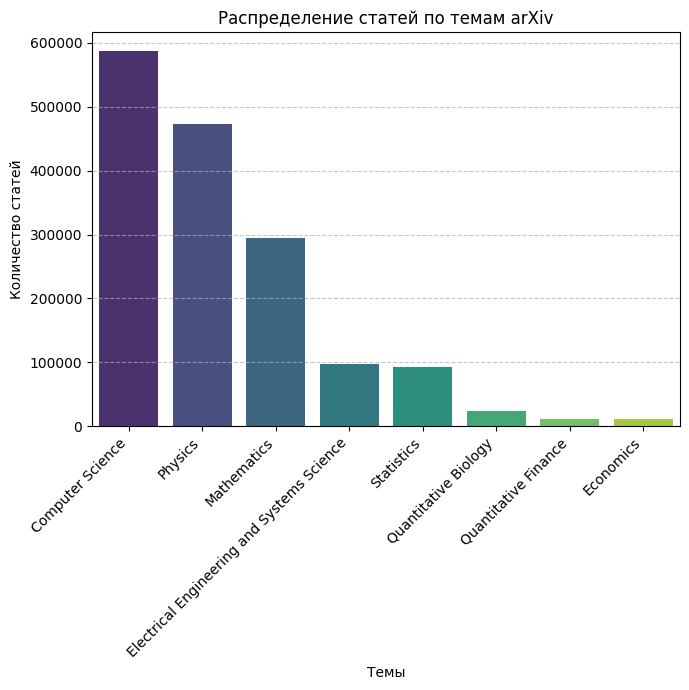

In [ ]:
# Построим распределение статей по темам
topic_counts = df["topics"].explode().value_counts().sort_values(ascending=False).reset_index()
topic_counts.columns = ["topic", "count"]

plt.figure(figsize=(7, 7))
sns.barplot(
    data=topic_counts,
    x="topic",
    y="count",
    hue="topic",
    dodge=False,
    palette="viridis",
    legend=False
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Темы")
plt.ylabel("Количество статей")
plt.title("Распределение статей по темам arXiv")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
topic_counts

,topic,count
0,Computer Science,587130
1,Physics,472609
2,Mathematics,295232
3,Electrical Engineering and Systems Science,97852
4,Statistics,92044
5,Quantitative Biology,23931
6,Quantitative Finance,12170
7,Economics,11082


Что ж, картина выглядит куда интереснее. Несмотря на несбалансированность классов, количества статей по каждой теме должно хватить для обучения трансформера. Подготовим датасет.

In [ ]:
y = df['topics']

In [ ]:
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(y)

In [ ]:
labels_df = pd.DataFrame(Y, columns=mlb.classes_)

In [ ]:
df['text'] = df['title'] + ' ' + df['summary']

In [ ]:
df_encoded = pd.concat([df[["text"]], labels_df], axis=1)

In [ ]:
df_encoded.head(10)

,text,Computer Science,Economics,Electrical Engineering and Systems Science,Mathematics,Physics,Quantitative Biology,Quantitative Finance,Statistics
0,Entanglement harvesting in the presence of a r...,0,0,0,0,1,0,0,0
1,Energy Performance Analysis of Distributed Ren...,1,0,1,0,0,0,0,0
2,Dynamic system optimal traffic assignment with...,1,0,0,1,0,0,0,0
3,Multi-task Retrieval for Knowledge-Intensive T...,1,0,0,0,0,0,0,0
4,A Two Stage Adaptive Metropolis Algorithm We p...,0,0,0,0,0,0,0,1
5,On the heat equation with drift in $L_{d+1}$ I...,0,0,0,1,0,0,0,0
6,Simple close curve magnetization and applicati...,0,0,0,1,0,0,0,0
7,WARP: Word-level Adversarial ReProgramming Tra...,1,0,0,0,0,0,0,0
8,Generative Max-Mahalanobis Classifiers for Ima...,1,0,0,0,0,0,0,0
9,Intent Classification and Slot Filling for Pri...,1,0,0,0,0,0,0,0


In [ ]:
# Разделим датасет на трейн и тест
train_df, val_df = train_test_split(df_encoded, test_size=0.1, random_state=42)

In [ ]:
# Инициализируем токенайзер
model_name = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Преобразуем трейн и тест в экземпляры `Dataset`
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
# Токенизируем датасет
train_dataset = train_dataset.map(tokenize_and_format)
val_dataset = val_dataset.map(tokenize_and_format)

Map:   0%|          | 0/1136961 [00:00<?, ? examples/s]

Map:   0%|          | 0/126330 [00:00<?, ? examples/s]

In [ ]:
# Удалим ненужные колонки из датасета
train_dataset = train_dataset.remove_columns(train_df.columns.difference(["text"] + mlb.classes_).tolist())
val_dataset = val_dataset.remove_columns(val_df.columns.difference(["text"] + mlb.classes_).tolist())

## 13. Обучение модели

In [ ]:
# Инициализируем модель
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Настроим параметры обучения модели
training_args = TrainingArguments(
    output_dir="./raw_data/results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./raw_data/logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
)

In [ ]:
# Инициализируем трейнер
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
# Обучим модель
trainer.train(resume_from_checkpoint=True)

Could not locate the best model at ./results/checkpoint-426363/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=426363, training_loss=0.0, metrics={'train_runtime': 0.0035, 'train_samples_per_second': 972554738.982, 'train_steps_per_second': 121570090.846, 'total_flos': 4.518791446950789e+17, 'train_loss': 0.0, 'epoch': 3.0})

## 14. Оценка модели

In [ ]:
# Посчитаем метрики
predictions = trainer.predict(val_dataset)
preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()
true = predictions.label_ids.astype(int)

In [ ]:
# Выведем отчёт
print(classification_report(true, preds, target_names=mlb.classes_, zero_division=0))

                                            precision    recall  f1-score   support

                          Computer Science       0.94      0.95      0.94     58706
                                 Economics       0.77      0.61      0.68      1121
Electrical Engineering and Systems Science       0.74      0.68      0.71      9755
                               Mathematics       0.91      0.87      0.89     29441
                                   Physics       0.97      0.95      0.96     47344
                      Quantitative Biology       0.75      0.62      0.68      2316
                      Quantitative Finance       0.77      0.70      0.73      1215
                                Statistics       0.77      0.61      0.68      9073

                                 micro avg       0.92      0.89      0.90    158971
                                 macro avg       0.83      0.75      0.78    158971
                              weighted avg       0.92      0.89      0.90 

На этот раз метрики выглядят значительно лучше.

## 15. Попытка обучить ещё бóльшую модель

Можно попробовать обучить `microsoft/deberta-v3-base`, правда, обучение может занять довольно много времени. Попробуем обучить на одной эпохе и посмотреть метрики. Есть шанс, что даже после одной эпохи модель покажет лучшие результаты и тогда её можно будет брать в прод. А если метрики будут хуже, то, в зависимости от ресурсов, либо возьмём предыдущую модель, либо ещё пообучаем эту.

In [ ]:
# Инициализируем токенайзер
model_name_2 = "microsoft/deberta-v3-base"
tokenizer_2 = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Инициализируем модель
model_deberta = AutoModelForSequenceClassification.from_pretrained(
    model_name_2,
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification"
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Настроим параметры обучения модели
training_args_deberta = TrainingArguments(
    output_dir="./raw_data/results_deberta",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,  # DeBERTa тяжелее!
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./raw_data/logs_deberta",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    save_total_limit=2,  # чтобы не забить диск
)

In [ ]:
# Инициализируем трейнер
trainer = Trainer(
    model=model_deberta,
    args=training_args_deberta,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer_2,
    compute_metrics=compute_metrics,
)

In [ ]:
# Обучим модель
trainer.train(resume_from_checkpoint=True)

Could not locate the best model at ./results_deberta/checkpoint-284241/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=284241, training_loss=0.0, metrics={'train_runtime': 0.0031, 'train_samples_per_second': 371196393.722, 'train_steps_per_second': 92799343.291, 'total_flos': 2.9916848898994176e+17, 'train_loss': 0.0, 'epoch': 1.0})

In [ ]:
# Посчитаем метрики
predictions = trainer.predict(val_dataset)
preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()
true = predictions.label_ids.astype(int)

In [ ]:
# Выведем отчёт
print(classification_report(true, preds, target_names=mlb.classes_, zero_division=0))

                                            precision    recall  f1-score   support

                          Computer Science       0.00      0.00      0.00     58706
                                 Economics       0.00      0.00      0.00      1121
Electrical Engineering and Systems Science       0.00      0.00      0.00      9755
                               Mathematics       0.00      0.00      0.00     29441
                                   Physics       0.37      1.00      0.55     47344
                      Quantitative Biology       0.00      0.00      0.00      2316
                      Quantitative Finance       0.00      0.00      0.00      1215
                                Statistics       0.00      0.00      0.00      9073

                                 micro avg       0.37      0.30      0.33    158971
                                 macro avg       0.05      0.12      0.07    158971
                              weighted avg       0.11      0.30      0.16 

В общем, на одной эпохе метрики несоизмеримо хуже, чем у предыдущей модели. Так как задача комплексная и в реальности такие задачи подразумевают итеративное улучшение, можно брать лучшую на текущий момент модель и использовать её для сервиса. В будущем можно будет попробовать дообучить модель `deberta-v3-base` или попробовать какие-то другие.

## 16. Выбор модели для прода

По результатам оценки для продакшна возьмём обученную на полном наборе данных модель `distilbert`.

## 17. Создание сервисов вокруг обученной модели

Сервис будет состоять из следующих компонентов:

1. Микросервис (воркер) с моделью
2. Фронтенд на gradio
3. Телеграм-бот (на aiogram)
4. Брокер сообщений (NATS)

Такая архитектура во-первых, позволит горизонтально масштабироваться в случае возрастания нагрузки (за счёт поднятия нескольких инстансов воркеров), а во-вторых, использовать одну и ту же модель для разных интерфейсов (веб-браузер, бот, API и т.п.)

## 18. Подготовка сервера для размещения проекта

Так как в наличии есть компьютер с видеокартой **rtx3090**, то имеет смысл микросервис с моделью разместить на нём. При этом компьютер находится за NAT провайдера, а потому недоступен извне. Для работы телеграм-бота это не является проблемой, если запускать его на поллинге, а для веб-сервиса желателен белый IP-адрес. Можно, конечно, разместить его на бесплатных ресурсах, типа, huggingface или на серверах самого gradio, но в таком случае остаётся намного меньше контроля, и это недостаточно удобно, если настраивать нормальный CI/CD.

С учётом того, что в наличии есть арендованный маломощный сервер с белым IP, - можно настроить на компьютере с видеокартой обратный туннель с пробросом портов веб-сервера gradio наружу. Для бесперебойной работы туннеля необходимо оформить его как `systemd`-сервис, который будет автоматически перезапускаться в случае сбоев.

## 19. Настройка всех компонентов проекта на сервере

Для автоматизации развёртывания хорошо подходит Docker, но в случае с моделью, требующей доступка к GPU, нужны дополнительные настройки. На текущий момент микросервис запущен как `systemd`-сервис, а перенос в Docker можно планировать как дальнейшее улучшение сервиса. Телеграм-бот и веб-сервер gradio разворачиваются в докере.

Также для сохранения информации о пользователях бота поднята СУБД PostgreSQL также в докере. В качестве брокера сообщений используется NATS (также в докере).

## 20. Запуск и тестирование развёрнутого сервиса

На текущий момент демо-сервис классификации научных статей по темам доступен по следующим ссылкам:

1. **Телеграм-бот**: [https://t.me/arxiv_topic_classifier_bot](https://t.me/arxiv_topic_classifier_bot)
2. **Веб-сервер**: [http://77.73.71.233:7860](http://77.73.71.233:7860)

## 21. Возможные направления для улучшения

1. Обучение более мощных моделей, если требуется ещё большая точность классификации.
2. Настройка автоматизированного пайплайна CI/CD.
3. Доработка веб-интерфейса (выбор другого дизайна, добавление функционала).
4. Проведение нагрузочного тестирования, чтобы оценить сколько пользователей одновременно комфортно могут пользоваться сервисом.
5. Переезд на k8s для автоматизации масштабирования
6. Доработка функционала телеграм-бота (в частности, можно сохранять запросы пользователей для дальнейшего анализа)
7. Переезд с `gradio` на какой-нибудь `npx`